# Première analyse 
Dans ce notebook nous effectuons une analyse préliminaire des données afin d'orienter nos choix de modélisation.

In [7]:
#### Imports des libraires et définition des fonctions nécessaires nécessaires. ####

from scipy.stats import pearsonr
import statsmodels.api
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickles
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Fonctions de pairgrid personnalisée
def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


def pairgrid(dataframe: pd.DataFrame):
    g = sns.PairGrid(dataframe, diag_sharey=False)
    g = g.map_offdiag(pairgrid_heatmap, bins=50, color="#880000")
    g = g.map_diag(sns.histplot)


# Fonction de génération de heatmap
def heatmap(dataframe: pd.DataFrame, center = 0, vmax = 1):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(dataframe, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataframe, cmap=cmap, vmax=vmax, center=center,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Fonction de calcul de p values de façon systématique
def p_values(dataframe: pd.DataFrame):

    types = dataframe.dtypes

    output = pd.DataFrame(columns=dataframe.columns)

    for (col_a, type_a) in types.iteritems():
        for (col_b, type_b) in types.iteritems():
            
            # Effectuer le test statistique correspondant à chaque types de colonnes.
            if type_a == 'object' or type_b == 'object':
                continue
            elif pd.api.types.is_categorical_dtype(type_a) and pd.api.types.is_categorical_dtype(type_b):
                table = pd.crosstab(dataframe[col_a], dataframe[col_b], normalize=0)
                p_value = chi2_contingency(table)[1]
            elif pd.api.types.is_categorical_dtype(type_a):
                anova = statsmodels.formula.api.ols(
                    f'{col_b} ~ {col_a}', data=dataframe).fit()
                table = statsmodels.api.stats.anova_lm(anova)
                p_value = table.at[col_a, 'PR(>F)']
            elif pd.api.types.is_categorical_dtype(type_b):
                anova = statsmodels.formula.api.ols(
                    f'{col_a} ~ {col_b}', data=dataframe).fit()
                table = statsmodels.api.stats.anova_lm(anova)
                p_value = table.at[col_b, 'PR(>F)']
            else:
                p_value = pearsonr(dataframe[col_a].values, dataframe[col_b].values)[1]
                
            # Mettre à jour le tableau final.
            output.at[col_a, col_b] = 1 if p_value < 0.05 else 0

    return output.fillna(0)


_Commentaire_ : <br>Les graphes peuvent être très denses, pour de l'analyse plus fine il faudrait les mettre en forme différemment. Il suffisent toutefois à apprécier d'un coup d'oeil l'interdépendance des variables. <br>Par ailleurs à date il rest encore quelques nettoyages à faire sur la base de données, au niveau de la labellisation et des jointures notamment.


## Comparaison semaine à semaine
Étant donné que la prédiction à effectuer porte sur la semaine suivant la fin du jeu de données, nous pouvons faire quelques analyses en rapport avec cette unité de temps.

In [5]:
transactions = pd.read_pickle('pickles/transactions_clean.pkl')

In [4]:
transactions['t_dat'].max()

Timestamp('2020-09-22 00:00:00')

#### Corrélations entre les ventes d'articles des différentes semaines 

In [15]:
### Aligner les numéros de semaine d'une année sur l'autre pour des fins d'analyse, afin que la semaine 0 et 52 soient alignées.
transactions['day_number'] = (transactions['t_dat'].max() - transactions['t_dat'] ).dt.days
transactions.loc[transactions['day_number'] > 345, 'week_number'] = ((transactions['t_dat'].max() - transactions['t_dat'] ).dt.days - 366) // 7 + 52

### Calcul du nombre de ventes par articles par semaine
transactions['article_id'] = transactions['article_id'].astype('int32')
weekly_sales = transactions.groupby(['article_id', 'week_number'], as_index = False).agg(
    sales  = ('article_id', 'count')
)

weekly_sales['sales'] = weekly_sales['sales'].astype('int32')

### Copie dans un tableau avec le numéro de semaine en colonne
weeks_to_compare = [0, 1, 2, 51, 52, 53, 54, 10, 20, 30, 40]

article_ids = weekly_sales['article_id'].unique()
week_board = pd.DataFrame({'article_id': article_ids})

for week_number in weeks_to_compare:
    week_sales = weekly_sales[weekly_sales['week_number'] == week_number][['article_id', 'sales']].rename({'sales' : f"Semaine n°{week_number}"}, axis = 1)
    
    week_board = week_board.merge(week_sales, on = 'article_id', how = 'left')
    
week_board.fillna(0, inplace=True)

week_board.set_index('article_id', inplace = True)

week_board.head(8)

,Semaine n°0,Semaine n°1,Semaine n°2,Semaine n°51,Semaine n°52,Semaine n°53,Semaine n°54,Semaine n°10,Semaine n°20,Semaine n°30,Semaine n°40
article_id,,,,,,,,,,,
108775015,0.0,0.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0
108775044,2.0,2.0,1.0,3.0,3.0,4.0,4.0,11.0,11.0,1.0,4.0
108775051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110065001,0.0,0.0,0.0,7.0,2.0,4.0,5.0,0.0,0.0,2.0,4.0
110065002,0.0,0.0,0.0,5.0,1.0,1.0,2.0,2.0,0.0,1.0,3.0
110065011,0.0,0.0,0.0,6.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0
111565001,25.0,27.0,27.0,37.0,24.0,35.0,28.0,24.0,37.0,32.0,70.0
111565003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

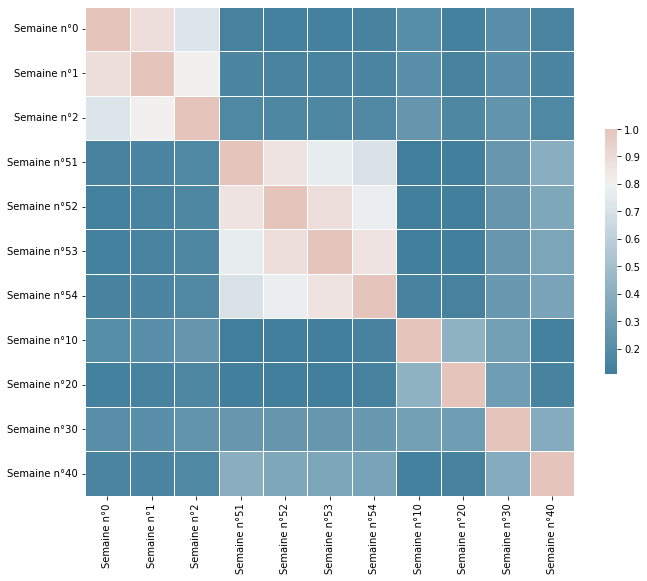

In [16]:
# Affichage sous forme de heatmap
table = week_board.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(table, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(table, cmap=cmap, vmax=1, center=0.8,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


On voit que les ventes des semaines 0-1 et 1-2 sont correlées à plus de 80%, de même que pourles semaines 52-51 (= 0-1 un an avant) : **On peut donc partir du principe que la semaine 0 et éventuellement la semaine 1 sont proches de la semaine de test.**

Par contre, on voit que **les ventes des semaines 0-1-2 sont très peu corrélées avec celles des semaines 51-52-53 un an avant.** Ces dernières ne constitueraient donc pas un bon jeu d'entraînement.

#### Nombre d'utilisateurs et de transactions par semaine

Text(0, 0.5, 'Nombre de transactions')

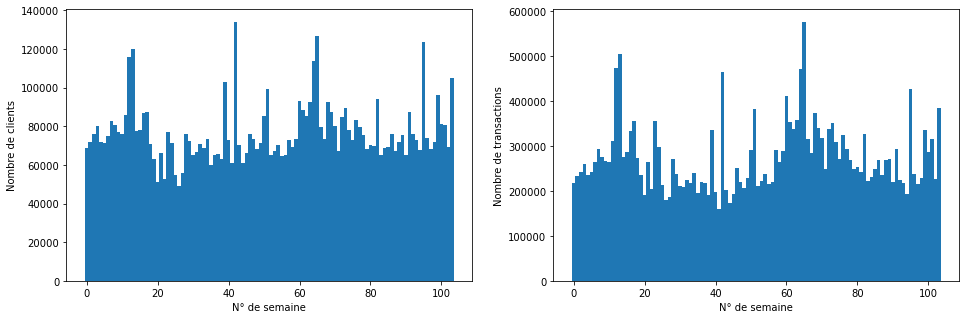

In [6]:
transactions_per_weeks = []
customers_per_weeks = []

first_week = transactions['week_number'].max() - 1  # -1 afin de partir d'une semaine entière.

x = range(first_week, -1, -1) # Abscisse de nos graphes.

for i in range(first_week, -1, -1):
    transactions_per_week = transactions[transactions['week_number'] == i]
    
    transactions_per_weeks.append(len(transactions_per_week))
    
    customers_per_weeks.append(transactions_per_week['customer_id'].unique().shape[0])
    
plt.figure(figsize=(16,5))    
plt.subplot(1,2,1)
plt.bar(x, customers_per_weeks, width=1)
plt.xlabel("N° de semaine")
plt.ylabel('Nombre de clients')

plt.subplot(1,2,2)
plt.bar(x, transactions_per_weeks, width=1)
plt.xlabel("N° de semaine")
plt.ylabel('Nombre de transactions')


Chaque semaine du jeu de données contient en moyenne 200 000 transactions pour 70 000 clients.

**En corollaire, le score final ne sera calculé que sur moins de 10% des utilisateurs.**

#### Répartition des ventes d'articles sur la dernière semaine

In [17]:
# Calcul des ventes par articles sur la dernière semaine (sans tenir compte du champ quantité)
last_week_sales = transactions[transactions['week_number'] == 0].groupby('article_id', as_index = False).agg(
    sales = ('article_id', 'count')
).sort_values('sales', ascending = False)
last_week_sales.head(5)

,article_id,sales
17308,924243001,779
16961,918522001,581
17309,924243002,546
17287,923758001,528
11827,866731001,487


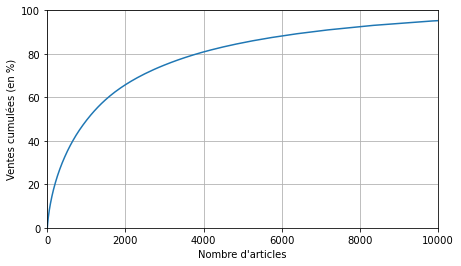

In [41]:
# Affichage d'un graphe avec part cumulative des articles sur les ventes totales

total_sales = last_week_sales['sales'].sum()

cumulative_sales = [0]
index = 0

while index < 10000:
    sales = last_week_sales.iloc[index, 1]
    previous_sum = cumulative_sales[-1]
    cumulative_sales.append(sales + previous_sum)
    
    index += 1
    
x = range(0, len(cumulative_sales))

plt.figure(figsize = (7, 4))
plt.plot(x, cumulative_sales / total_sales * 100)
plt.xlabel("Nombre d'articles")
plt.xlim((0, 10000))
plt.ylabel("Ventes cumulées (en %)")
plt.ylim((0, 100))

plt.grid(True)

80% des ventes de la dernière semaine sont faites sur 4000 références. Les 1000 articles les plus vendus représentent la moitié des ventes. Dans cette optique il est sans doute possible d'entraîner le modèle sur une shortlist d'articles plutôt que sur toutes les références.

## Visualisations par caractéristiques d'article

In [4]:
transactions_sampled = pd.read_pickle('pickles/transactions_all_infos.pkl')
transactions_sampled = transactions_sampled.sample(frac = 0.5)

In [6]:
articles = pd.read_pickle('pickles/articles_clean.pkl')

#### Par catégorie (Index)

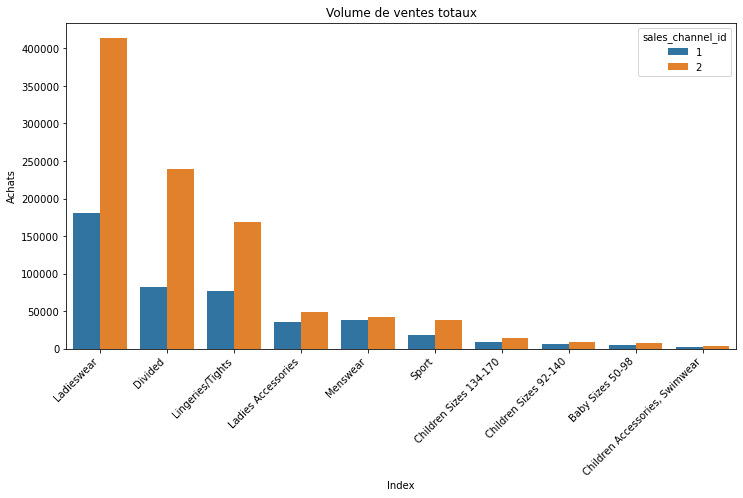

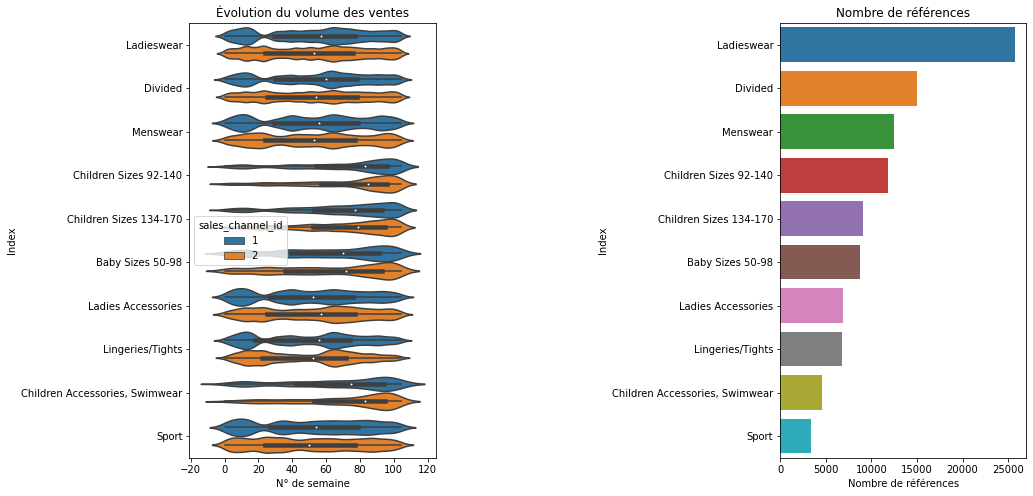

In [78]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation=45, ha = 'right')

sns.countplot(
    x=transactions_sampled['index_name'],
    hue=transactions_sampled['sales_channel_id'],
    order=transactions_sampled['index_name'].value_counts().index
).set(
    ylabel='Achats', 
    xlabel='Index',
    title = "Volume de ventes totaux"
)

plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 8))


sns.violinplot(
    y='index_name',
    x='week_number',
    kind='violin',
    hue='sales_channel_id',
    data=transactions_sampled,
    order=articles['index_name'].value_counts().index,
    height=6,
    ax = axes[0]
).set(
    xlabel='N° de semaine', 
    ylabel='Index',
    title = "Évolution du volume des ventes"
)

sns.countplot(
    y=articles['index_name'],
    order=articles['index_name'].value_counts().index,
    ax = axes[2]
).set(
    xlabel='Nombre de références', 
    ylabel='Index',
    title="Nombre de références"
)

axes[1].axis('off')


plt.show()




#### Par section

In [51]:
# Sections : on regarde s'il y a plusieurs index / group par section
sections_group = transactions_sampled.groupby('section_name').agg(
    {
        'index_name': "nunique",
        'index_group_name': 'nunique'
    }
)

print("Nombre de sections appartement à plus d'un groupe d'index: ", sections_group['index_group_name'].value_counts().iloc[1:].sum())

print("-> On considère donc que les sections sont organisées par groupe d'index.")


Nombre de sections appartement à plus d'un groupe d'index:  1
-> On considère donc que les sections sont organisées par groupe d'index.


In [ ]:

sns.catplot(
    y='section_name',
    kind='count',
    data=transactions_sampled,
    col="index_group_name",
    sharey=False,
    sharex=False
)


In [ ]:

sns.catplot(
    y='section_name',
    x='week_number',
    kind='violin',
    data=transactions_sampled,
    col="index_group_name",
    sharey=False,
)


#### Par type de vêtement

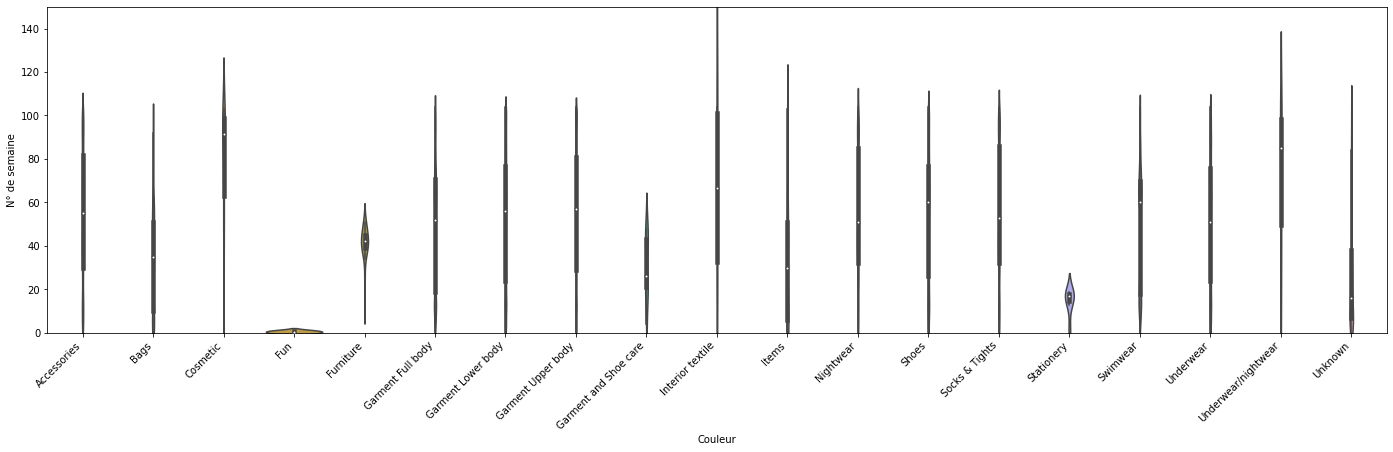

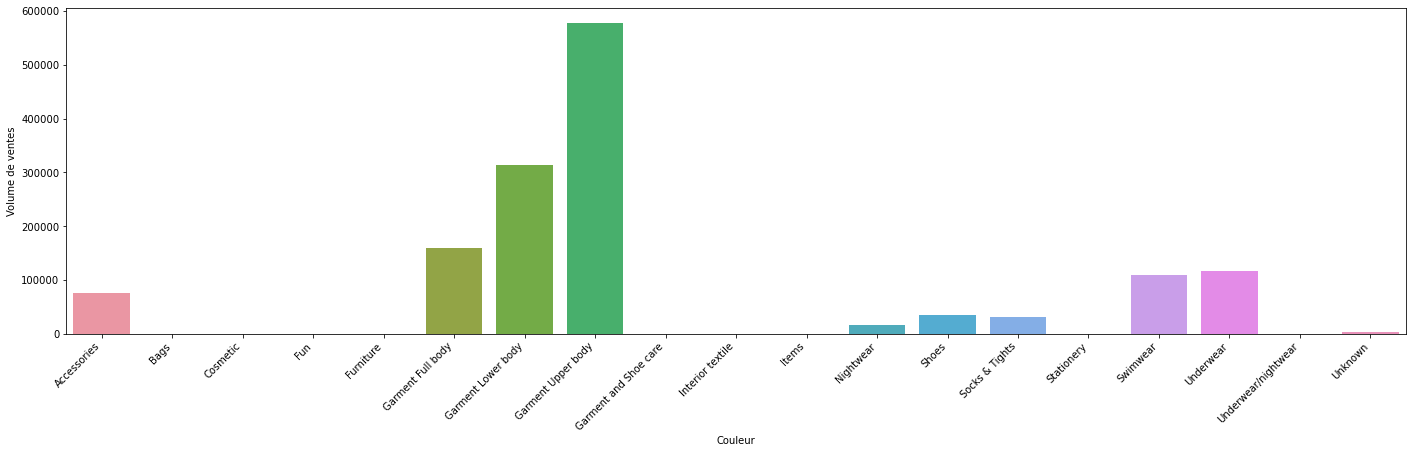

In [121]:

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')
g = sns.violinplot(
    x='product_group_name',
    y='week_number',
    kind='violin',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='N° de semaine', 
    xlabel='Couleur',
)
plt.ylim(0, 150)
plt.show()

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')

sns.countplot(
    x='product_group_name',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='Volume de ventes', 
    xlabel='Couleur',
)
plt.show()

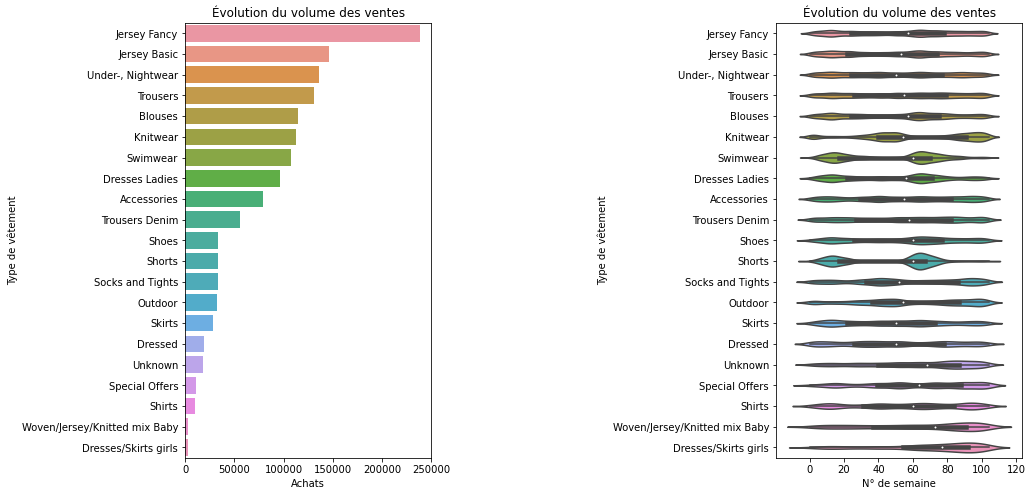

In [69]:

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

sns.countplot(
    y=transactions_sampled['garment_group_name'],
    order=transactions_sampled['garment_group_name'].value_counts().index,
    ax = axes[0]
).set(
    xlabel='Ventes', 
    ylabel='',
    title = "Évolution du volume des ventes"
)

axes[1].axis('off')

sns.violinplot(
    y='garment_group_name',
    x='week_number',
    kind='violin',
    data=transactions_sampled,
    order=transactions_sampled['garment_group_name'].value_counts().index,
    height=8,
    ax = axes[2]
).set(
    xlabel='N° de semaine', 
    ylabel='',
    title = "Volume des ventes"
)


plt.show()




#### Par caractéristiques

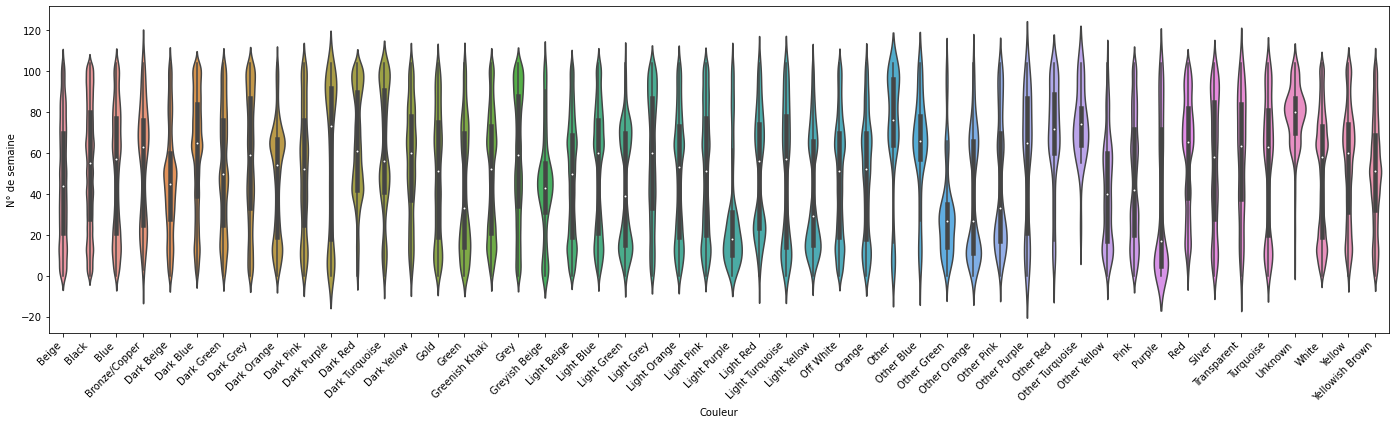

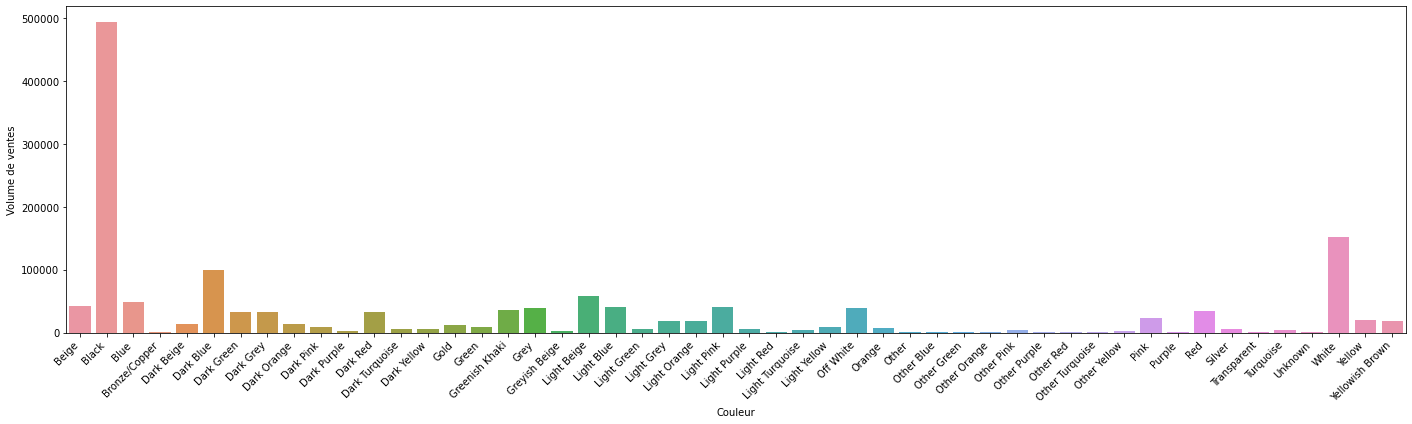

In [106]:

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')
g = sns.violinplot(
    x='colour_group_name',
    y='week_number',
    kind='violin',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='N° de semaine', 
    xlabel='Couleur',
)
plt.show()

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')

sns.countplot(
    x='colour_group_name',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='Volume de ventes', 
    xlabel='Couleur',
)
plt.show()


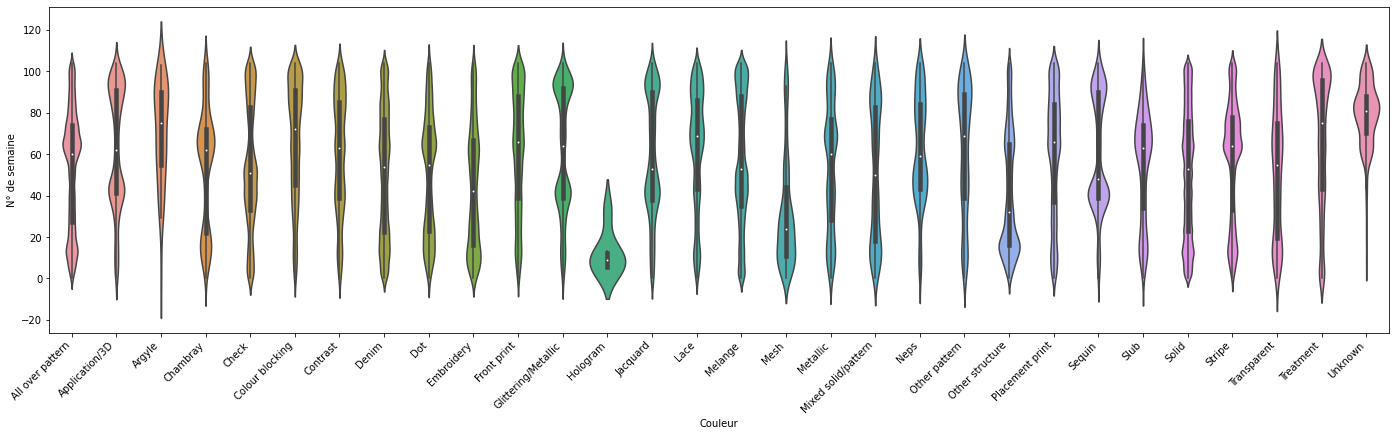

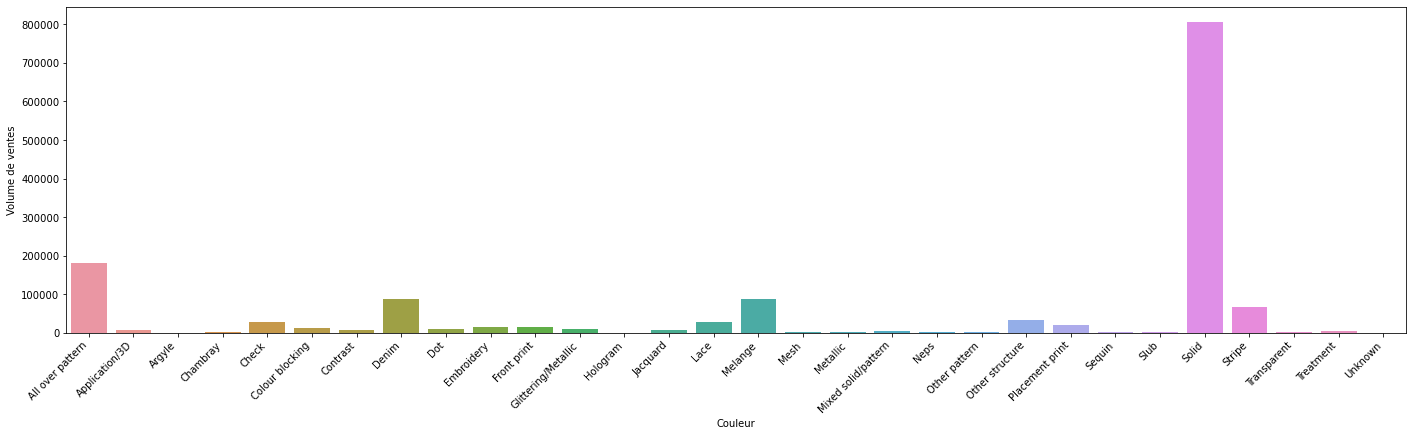

In [108]:

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')
g = sns.violinplot(
    x='graphical_appearance_name',
    y='week_number',
    kind='violin',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='N° de semaine', 
    xlabel='Couleur',
)
plt.show()

fig, axe = plt.subplots(figsize = (24, 6))
plt.xticks(rotation=45, ha = 'right')

sns.countplot(
    x='graphical_appearance_name',
    data=transactions_sampled,
    ax = axe
).set(
    ylabel='Volume de ventes', 
    xlabel='Couleur',
)
plt.show()

### Observations

- Prépondérance du canal 2, avec quelques variations selon le type de produit.
- La catégorie Ladieswear et la sous-catégorie "Women Everyday Collection" sont largement majoritaires.
- Les articles "Jersey fancy", "Black" et "Solid" sont largement majoritaires.
- Les caractéristiques du produit influent sur les ventes.
- Certaines caractéristiques ont toutefois une "signature temporelle" très marquée.


## Clients

In [135]:
customers = pd.read_pickle('pickles/customers_clean.pkl')
pd.options.display.float_format = '{:,.3f}'.format
customers.describe()

,FN,Active,age,average_cart_articles,average_cart_price,total_carts,total_articles,total_price,average_cart_interval
count,"1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000"
mean,0.348,0.338,35.966,3.130,0.086,6.687,23.170,0.582,8.600
std,0.476,0.473,14.753,2.350,0.069,9.873,39.152,1.045,12.557
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,24.000,1.769,0.044,1.000,3.000,0.081,0.000
50%,0.000,0.000,31.000,2.500,0.068,3.000,9.000,0.222,4.871
75%,1.000,1.000,49.000,4.000,0.105,8.000,27.000,0.640,11.405
max,1.000,1.000,99.000,78.000,4.064,433.000,"1,895.000",49.361,104.429


**Les champs `average_cart_articles`, `total_carts` et `total_articles` laissent apparaître des outliers, comme nous pouvons le voir plus précisément dans le tableau suivant :**

In [136]:
customers.describe( percentiles = [0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999])

,FN,Active,age,average_cart_articles,average_cart_price,total_carts,total_articles,total_price,average_cart_interval
count,"1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000","1,371,980.000"
mean,0.348,0.338,35.966,3.130,0.086,6.687,23.170,0.582,8.600
std,0.476,0.473,14.753,2.350,0.069,9.873,39.152,1.045,12.557
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,31.000,2.500,0.068,3.000,9.000,0.222,4.871
90%,1.000,1.000,57.000,5.833,0.163,17.000,59.000,1.472,22.000
95%,1.000,1.000,61.000,7.286,0.212,25.000,90.000,2.303,32.286
99%,1.000,1.000,71.000,12.000,0.348,46.000,187.000,4.971,63.857
99.9%,1.000,1.000,80.000,21.333,0.624,92.000,385.000,10.636,92.429
99.99%,1.000,1.000,88.000,35.000,1.013,162.000,667.604,19.215,101.543


In [143]:
# Description supplémentaire pour le champ "average_cart_interval"
customers[customers['average_cart_interval'] != 0]['average_cart_interval'].describe(percentiles = [0.25, 0.5, 0.75, 0.9, 0.97, 0.99])

count   914,308.000
mean         12.905
std          13.456
min           0.143
25%           4.875
50%           8.667
75%          15.690
90%          28.000
97%          49.286
99%          71.714
max         104.429
Name: average_cart_interval, dtype: float64

In [145]:
print("Proportion de clients n'ayant effectué qu'un seul panier : ", len(customers[customers['average_cart_interval'] == 0]) / len(customers))

Proportion de clients n'ayant effectué qu'un seul panier :  0.33358503768276504


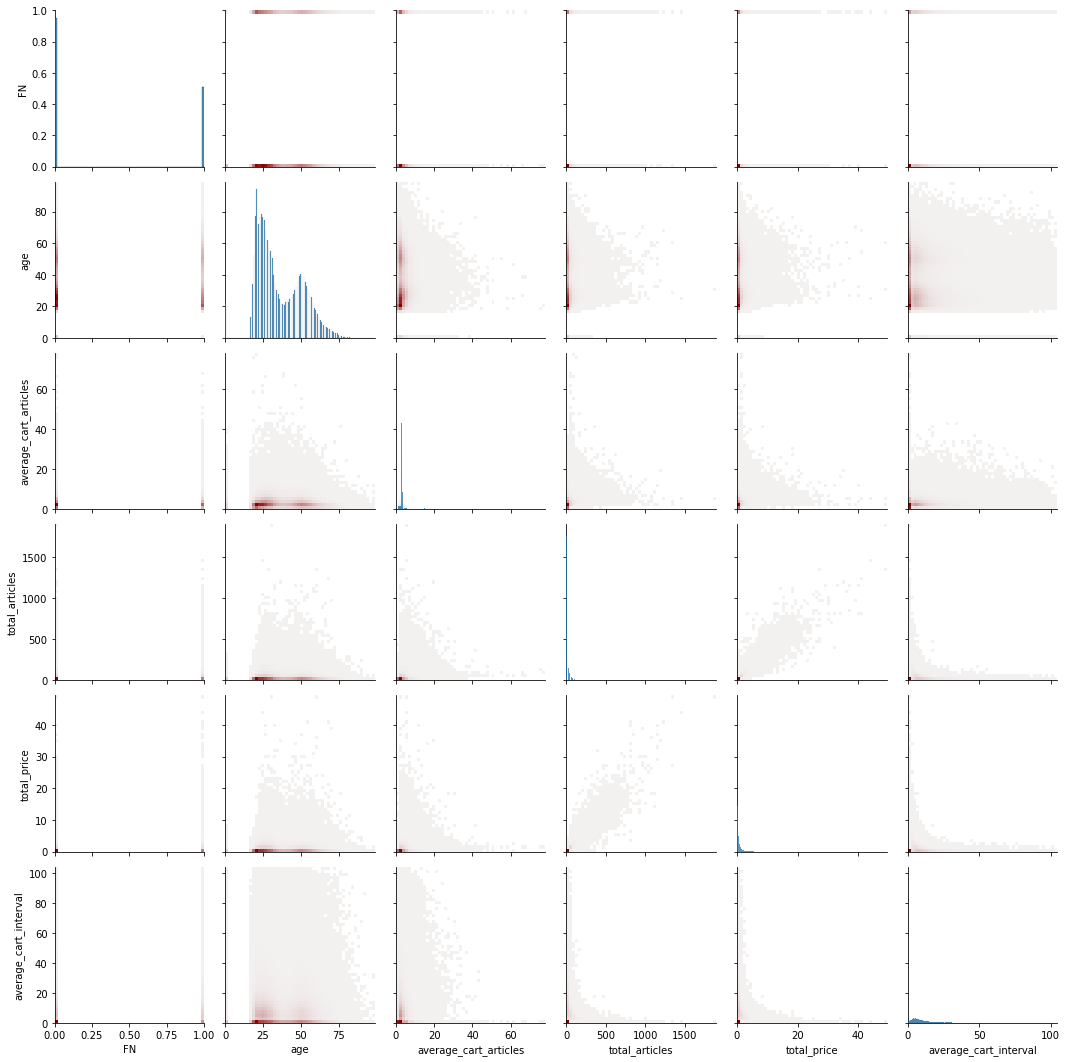

In [147]:
columns_to_analyze = [
    'FN',
    'age',
    'average_cart_articles',
    'total_articles',
    'total_price',
    'average_cart_interval',
]

pairgrid(customers[columns_to_analyze])


### Observations

- La distribution en âge des clients présente deux pics, à 25 et 50 ans.
- 1/3 des clients n'a qu'un seul panier d'enregistré au cours de la période. Pour les autres, 50% font un achat dans les neufs semaines et 97% dans l'année.
- 50% des clients ont plus de 3 paniers et de 9 articles.
- Pas de lien notable entre l'âge, l'inscription à la newsletter et les champs relatifs aux achats.

## Possibilités d'entraînement / validation sur un groupe restreint d'utilisateurs
nous regardons ici s'il peut être pertinent d'entraîner / valider un modèle sur une partie des utilisateurs, en considérants que les transactions de ses derniers sont représentatives de l'ensemble.

In [1]:
### Calcul préalable du nombre de ventes par articles par semaine
import pandas as pd

transactions = pd.read_pickle('pickles/transactions_clean.pkl')

transactions['article_id'] = transactions['article_id'].astype('int32')
weekly_sales = transactions.groupby(['article_id', 'week_number'], as_index = False).agg(
    sales  = ('article_id', 'count')
)

weekly_sales['sales'] = weekly_sales['sales'].astype('int32')

In [2]:
### Calcul préalable du nombre de ventes d'articles par client.
transactions_by_customer = transactions.groupby(['customer_id', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)

In [3]:
# Division de la table des clients en 50 paquets et calcul des ventes de chaque articles pour chacun des paquets.
customers = pd.read_pickle("pickles/customers_clean.pkl") 

buckets = 100

customer_per_bucket = len(customers) // buckets

article_ids = weekly_sales['article_id'].unique()

customer_sales_board = pd.DataFrame({'article_id': article_ids})
customer_unique_board = customer_sales_board.copy()

article_ids = customers.loc[0 : buckets * customer_per_bucket, 'customer_id']

print(f"{customer_per_bucket} clients par paquet.")

for i in range(100):
    print(f"\rProcessing bucket {i}", end="")
    customer_bucket = customers.loc[i * customer_per_bucket : i * customer_per_bucket + customer_per_bucket][['customer_id']]
    
    sales = customer_bucket.merge(transactions_by_customer, on='customer_id', how='left')
    sales = sales.groupby('article_id', as_index = False).agg(
        unique = ('customer_id', 'count'),
        sales = ('sales', 'sum')
    ).rename({'unique': f"unique_{i}", 'sales': f"Groupe n°{i}"}, axis = 1)
    
    customer_sales_board = customer_sales_board.merge(sales[['article_id', f"sales_{i}"]], on = 'article_id', how = 'left')
    customer_unique_board = customer_unique_board.merge(sales[['article_id', f"unique_{i}"]], on = 'article_id', how = 'left')
    
customer_sales_board.set_index('article_id', inplace = True)
customer_unique_board.set_index('article_id', inplace = True)

customer_sales_board.fillna(0, inplace = True)
customer_unique_board.fillna(0, inplace = True)

customer_sales_board.head(5)

13719 clients par paquet.
Processing bucket 99

,sales_0,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,...,sales_90,sales_91,sales_92,sales_93,sales_94,sales_95,sales_96,sales_97,sales_98,sales_99
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,71.0,71.0,89.0,61.0,88.0,78.0,82.0,87.0,67.0,89.0,...,73.0,79.0,79.0,62.0,66.0,89.0,68.0,64.0,62.0,74.0
108775044,61.0,52.0,75.0,63.0,76.0,54.0,74.0,75.0,47.0,55.0,...,45.0,48.0,53.0,53.0,41.0,61.0,43.0,59.0,57.0,57.0
108775051,4.0,2.0,5.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,...,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
110065001,9.0,11.0,7.0,11.0,14.0,5.0,8.0,6.0,11.0,12.0,...,15.0,6.0,8.0,10.0,10.0,9.0,7.0,7.0,10.0,8.0
110065002,3.0,6.0,2.0,7.0,6.0,5.0,2.0,4.0,5.0,6.0,...,10.0,2.0,7.0,3.0,2.0,5.0,4.0,9.0,5.0,7.0


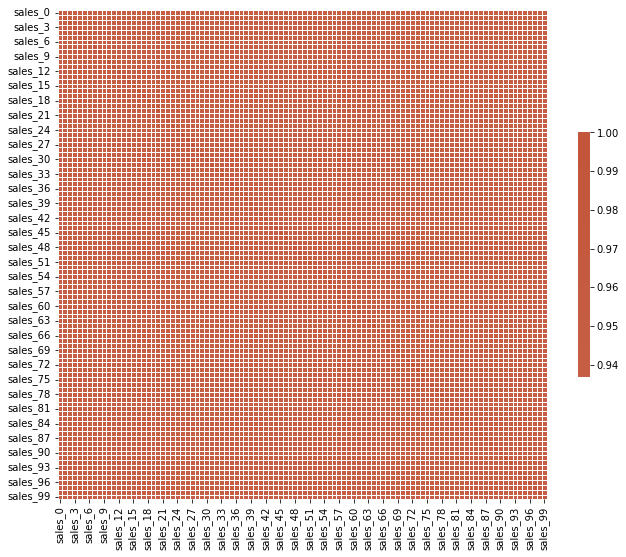

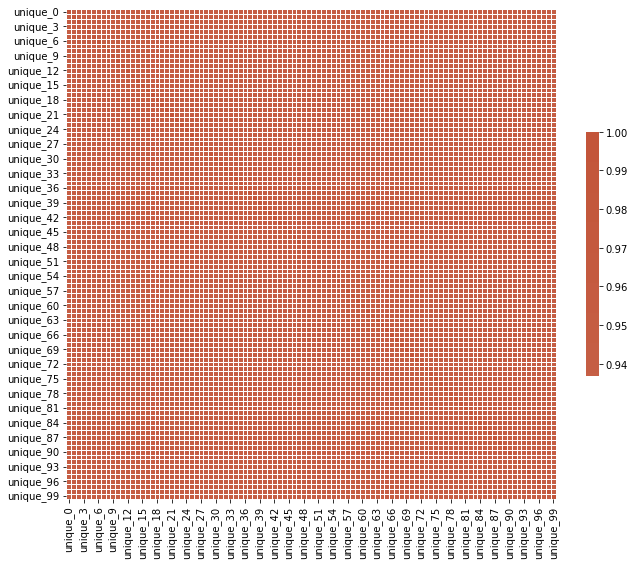

: 

In [7]:
heatmap(customer_sales_board.corr())
heatmap(customer_unique_board.corr())

Les répartitions des ventes et des articles ayant été achetés au moins une fois sont correlées à 94% entre les différents groupes de clients, et ce de façon uniforme.
On peut donc imaginer d'entraîner / valider notre modèle sur un nombre restreint d'utilisateurs.

## Analyse croisée transactions / clients / articles

In [9]:
# Chargement des données
transactions_sampled = pd.read_pickle('pickles/transactions_all_infos.pkl')
transactions_sampled = transactions_sampled.sample(frac = 0.5)

label_encoder = LabelEncoder()

columns_to_encode = [
    'club_member_status',
    'fashion_news_frequency',
    'perceived_colour_value_name',
    'product_type_name',
    'garment_group_name',
    'section_name'
]

for column in columns_to_encode:
    transactions_sampled[column] = label_encoder.fit_transform(
        transactions_sampled[column])


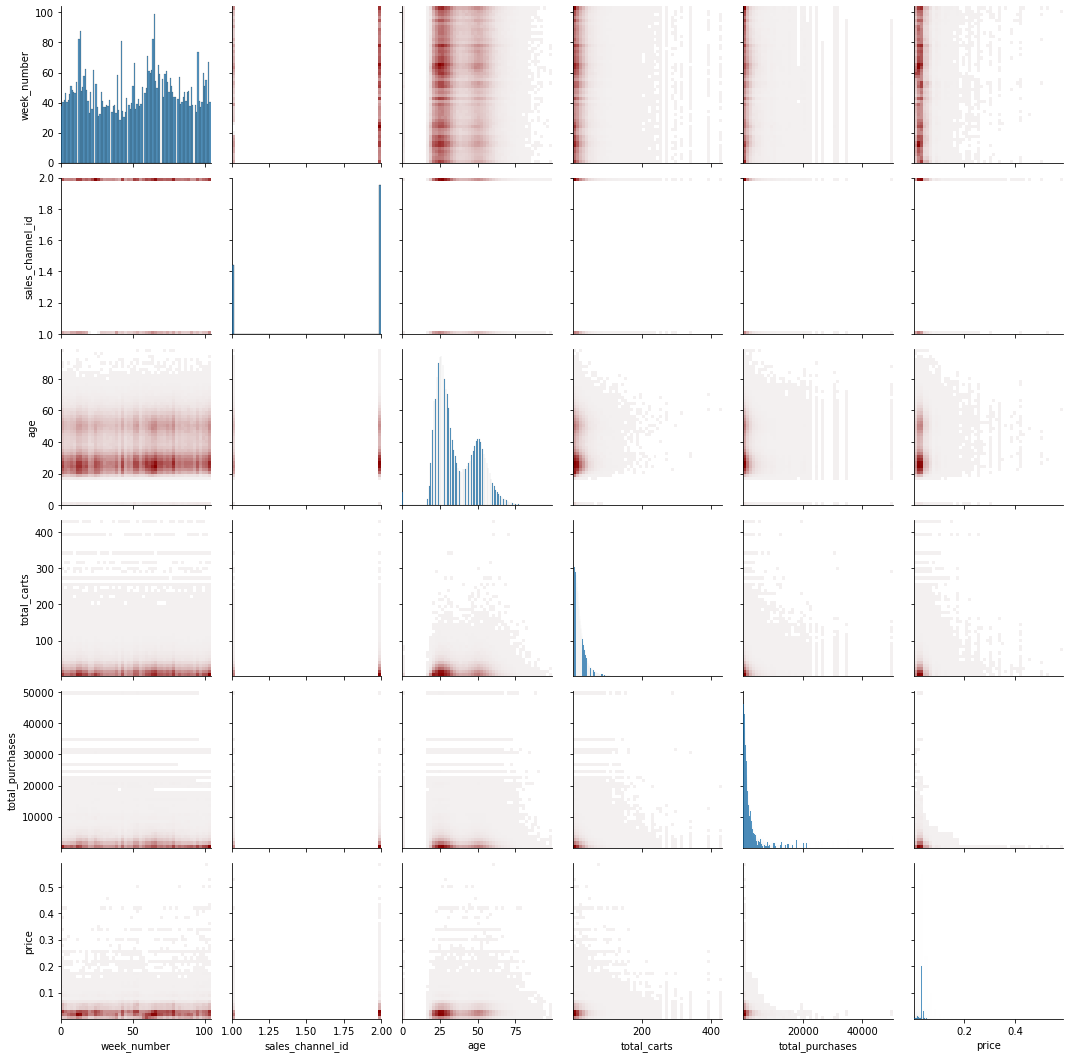

In [150]:
columns_to_analyze = [
    'week_number',
    'sales_channel_id',
    'age',
    'total_carts',
    'total_purchases',
    'price',
]

pairgrid(transactions_sampled[columns_to_analyze])


**Observations**

- Le volume des ventes dépend de la période dans une limite du simple au double, avec un minimum en début d'année et un maximum en milieu d'année.
- Deux fois plus de ventes sur le canal 2 que sur le canal 1.


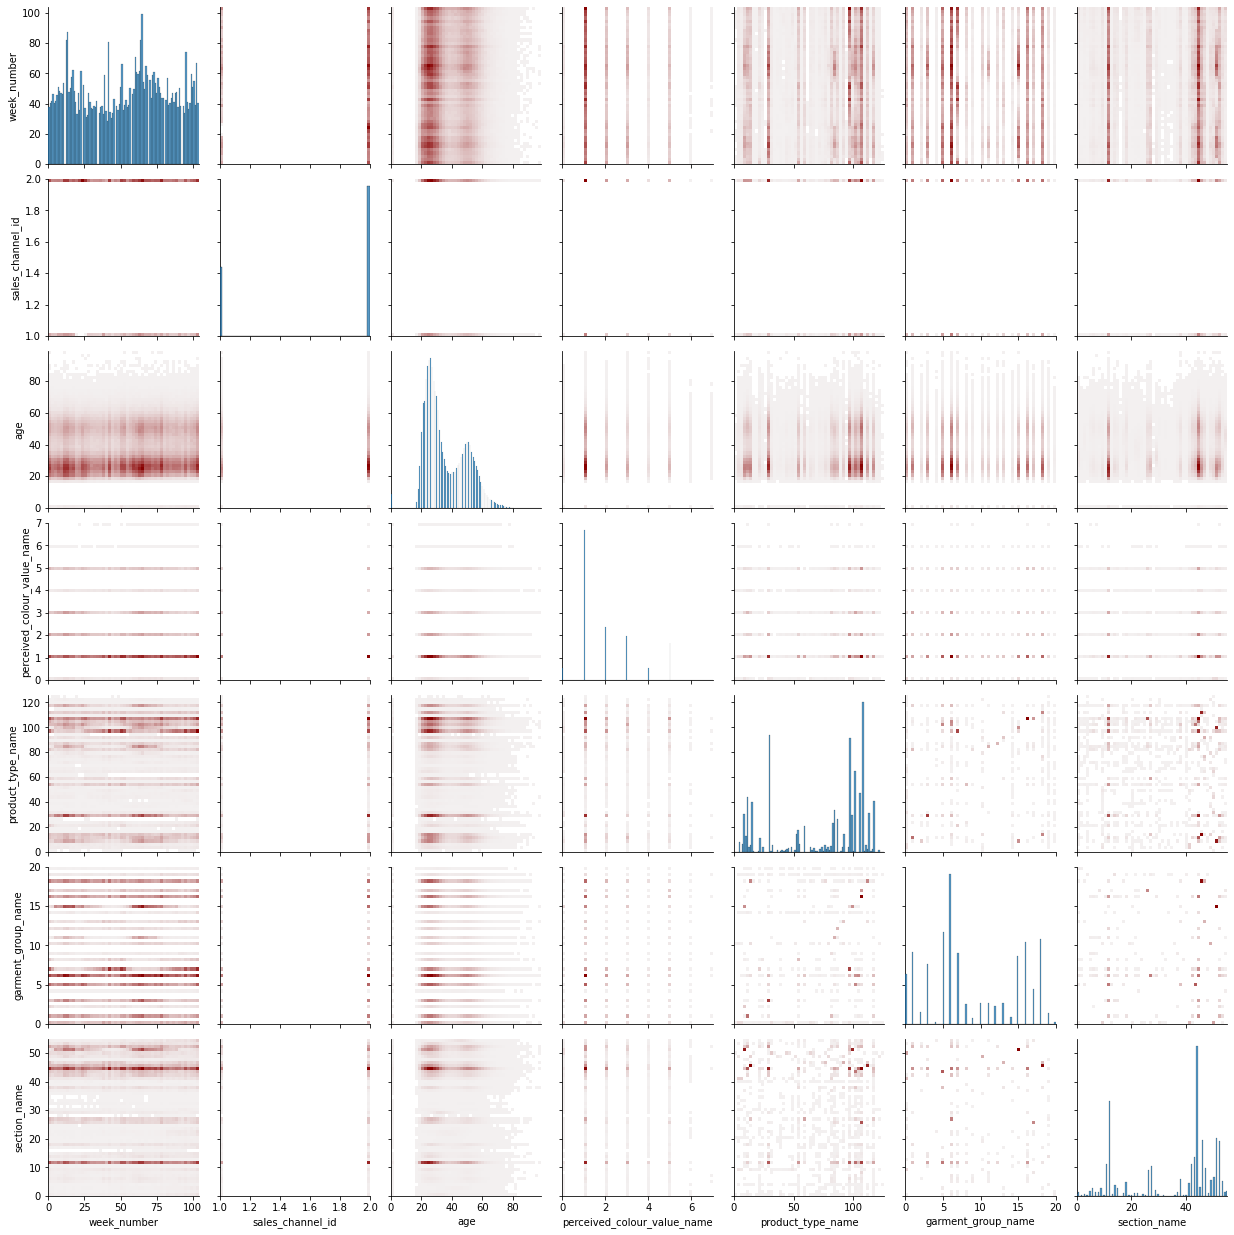

In [152]:
columns_to_analyze = [
    'week_number',
    'sales_channel_id',
    'age',
    'perceived_colour_value_name',
    'product_type_name',
    'garment_group_name',
    'section_name'
]

pairgrid(transactions_sampled[columns_to_analyze])


**Observations**

- On retrouve les variations des ventes par semaine selon les caratéristiques du produit, que nous avions identifiées plus haut. 
- On peut voir de légère variations dans les figures de ventes par caractéristiques selon l'âge du client (ligne n°3): les clients n'achètent pas tout-à-fait les mêmes articles au même âge.


#### Analyse de corrélation
Nous allons maintenant faire une analyse de corrélation systématique entre les différentes champs croisés Articles / Clients / Transactions.

/tmp/ipykernel_6043/63498989.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  corr = transactions_sampled.drop(["customer_id",


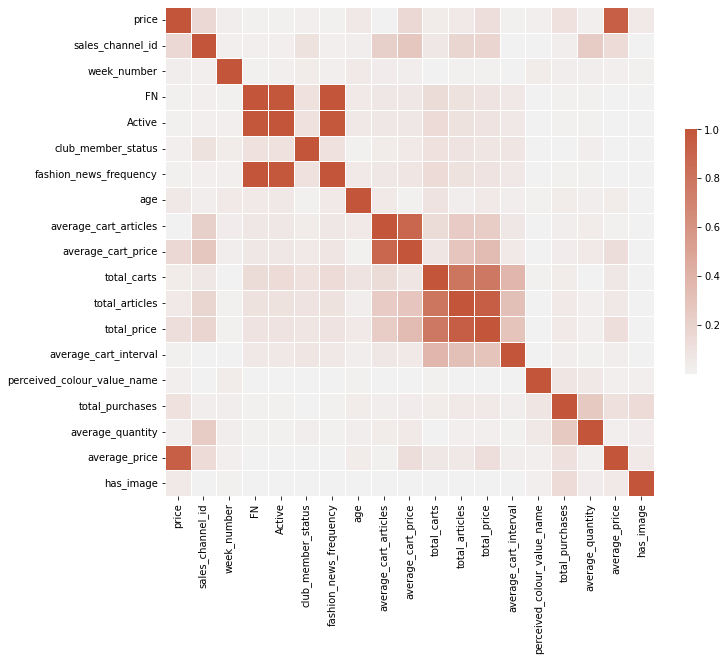

In [14]:
corr = transactions_sampled.drop(["customer_id",
                                  "article_id",
                                  "quantity",
                                  "prod_name",
                                  'product_code',
                                  'department_name',
                                  'section_name',
                                  'product_type_name',
                                  'section_no',
                                  'perceived_colour_master_name',
                                  'garment_group_name',
                                  'graphical_appearance_name'],
                                 1).corr()

heatmap(np.abs(corr))


#### Analyse systématique des p-values

In [9]:
transactions_sampled = pd.read_pickle('pickles/transactions_all_infos.pkl')
transactions_sampled = transactions_sampled.drop(
        columns = [
            "customer_id",
            "article_id",
            "quantity",
            "detail_desc",
            "t_dat",
            "postal_code",
            "product_type_name"
            ],
        axis = 1).sample(frac = 0.01)

transactions_sampled['has_image'] = transactions_sampled['has_image'].apply(lambda x: 1 if x else 0)

En rouge, les variables pour lesquelles on ne peut pas rejeter l'hypothèse d'indépendance.


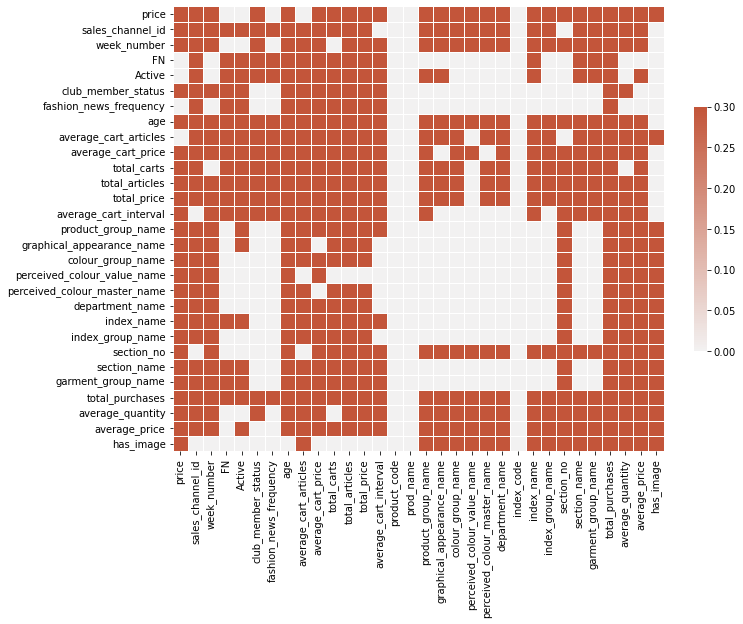

In [12]:
p = p_values(
    transactions_sampled)

print("En rouge, les variables pour lesquelles on ne peut pas rejeter l'hypothèse d'indépendance.")
heatmap(p)


In [34]:
dataframe = pd.DataFrame(columns=transactions_sampled.columns)


,customer_id,article_id,t_dat,price,sales_channel_id,quantity,day_of_week,day_of_year,FN,Active,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,total_purchases,average_quantity,average_price,has_image
bibi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**

- Le nombre d'achats (`total_carts`, `average_cart_articles`) et l'intervalle entre deux paniers (`average_cart_interval`) semblent légèrement corrélés avec l'âge du client.
- La période d'achat du produit (`day_of_year`) semble correllée avec : le canal de vente, les caractéristiques du produit et le nombre total d'achat du produit (`total_purchases`). Cette corrélation n'est toutefois pas très forte.
- Les champs propres au statut du membre (`club_member_status`, `fashion_news_frequency`) sont correlés avec ceux de sont comportement d'achat (`total_carts`, `total_articles`, etc)
- Le prix moyen du panier ainsi que le nombre moyen d'articles (`average_cart_price`, `average_cart_articles`) sont correlés avec le canal de vente de façon significative.
- Peu de variables que l'on peut considérer comme indépendantes.



## Analyse des paniers


In [3]:
carts = pd.read_pickle('pickles/carts_all_infos.pkl')
carts_sampled = carts.sample(frac=0.1)

In [4]:
carts_sampled.columns

Index(['customer_id', 't_dat', 'sales_channel_id', 'total', 'unique_articles',
       'total_articles_x', 'week_number', 'content', 'day_of_week',
       'day_from_origin', 'days_from_previous', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'average_cart_articles', 'average_cart_price', 'total_carts',
       'total_articles_y', 'total_price', 'average_cart_interval'],
      dtype='object')

In [10]:
carts_sampled[['unique_articles',
       'average_cart_articles',
       'average_cart_interval']].describe(percentiles = [.25, .50, .75, .90])

,unique_articles,average_cart_articles,average_cart_interval
count,917446.000000,917446.000000,917446.000000
mean,3.142259,3.138901,7.139851
std,2.999993,1.792830,7.988996
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,2.914286
50%,2.000000,2.674419,5.035714
75%,4.000000,3.733333,8.514286
90%,6.000000,5.194444,14.285714
max,71.000000,58.000000,104.285714


In [11]:
carts_sampled[carts_sampled['days_from_previous']
              != 0][['days_from_previous', 'average_cart_interval']].describe(percentiles = [.25, .50, .75, .90])


,days_from_previous,average_cart_interval
count,771404.000000,771404.000000
mean,48.283772,6.894725
std,71.604120,6.840208
min,1.000000,0.142857
25%,7.000000,3.125541
50%,22.000000,5.062500
75%,58.000000,8.238095
90%,124.000000,13.265306
max,729.000000,104.142857


**Observations**

- Il y a en moyenne 3 articles par panier (écart-type de 3)
- Les "premiers paniers" (= premier panier d'un client sur la période) représentent 15% du total.
- 50% des achats (hors premiers paniers) ont lieu dans les 22 jours de l'achat précédent.


In [21]:
# Encodage des labels
label_encoder = LabelEncoder()

columns_to_encode = [
    'club_member_status',
    'fashion_news_frequency'
]

for column in columns_to_encode:
    carts_sampled[column] = label_encoder.fit_transform(carts_sampled[column])


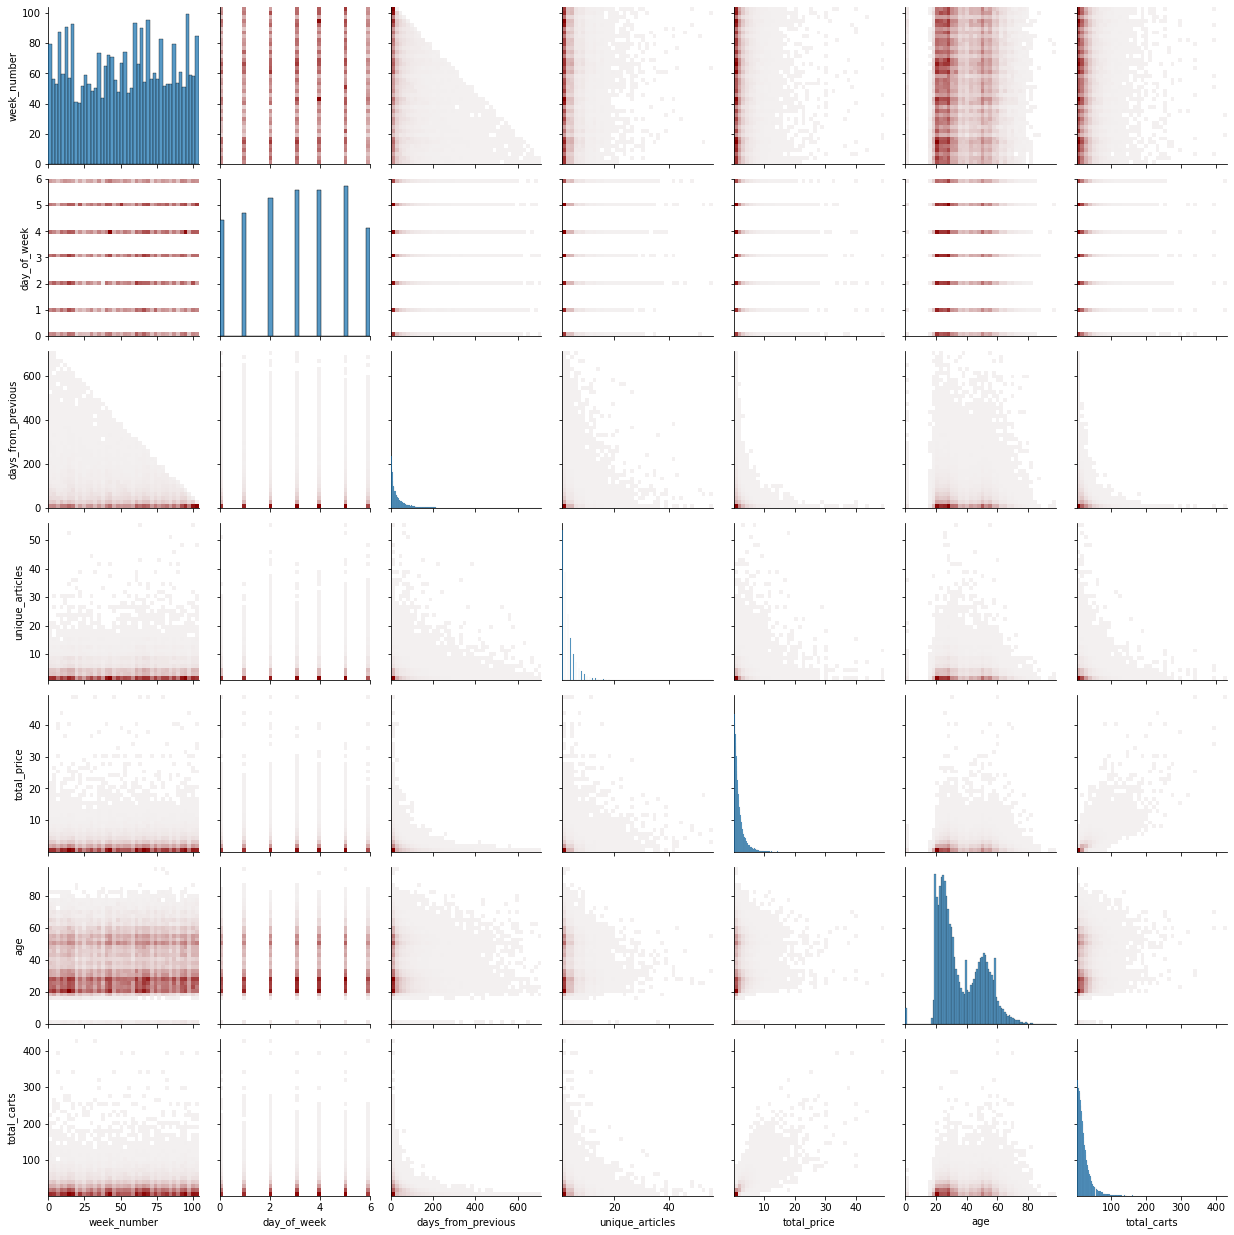

In [23]:
columns_to_analyze = [
    'week_number',
    'day_of_week',
    'days_from_previous',
    'unique_articles',
    'total_price',
    'age',
    'total_carts',
]


def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


g = sns.PairGrid(carts_sampled[columns_to_analyze], diag_sharey=False)
g = g.map_offdiag(pairgrid_heatmap, bins=40, color="#880000")
g = g.map_diag(sns.histplot)


**Observations**

- On retrouve les mêmes tendances que pour les transactions uniques.
- La composition, le prix du panier et l'intervalle entre deux paniers (`unique_articles`, `total_price`, `days_from_previous`) semblent correlés avec l'âge.
- Le prix total du panier (`total_price`) et l'intervalle entre deux paniers (`days_from_previous`) semblent correllés.
- Les jours de la semaine enregistrant le plus de ventes (`day_of_week`) semblent varier de façon hétérogène au cours de l'année. (`week_number`)


/tmp/ipykernel_10909/1824983539.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  corr = carts_sampled.drop(["customer_id", "t_dat" ], 1).corr()


<AxesSubplot:>

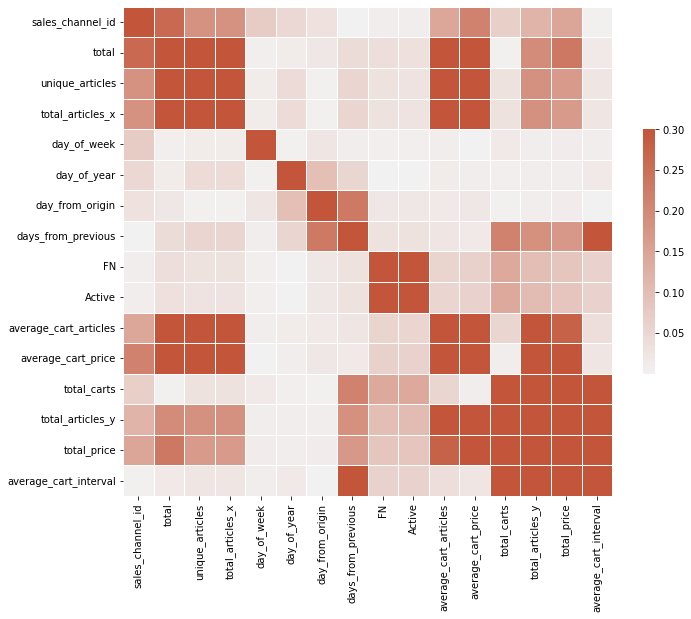

In [48]:

corr = carts_sampled.drop(["customer_id", "t_dat"], 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.abs(corr), cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#### Analyse systématique des p-values
En rouge, les variables pour lesquelles on ne peut pas rejeter l'hypothèse d'indépendance.

In [49]:
carts_sampled.columns

Index(['customer_id', 't_dat', 'sales_channel_id', 'total', 'unique_articles',
       'total_articles_x', 'content', 'day_of_week', 'day_of_year',
       'day_from_origin', 'days_from_previous', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'average_cart_articles', 'average_cart_price', 'total_carts',
       'total_articles_y', 'total_price', 'average_cart_interval'],
      dtype='object')

/tmp/ipykernel_19694/3158746622.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  p = p_values(carts_sampled.drop(


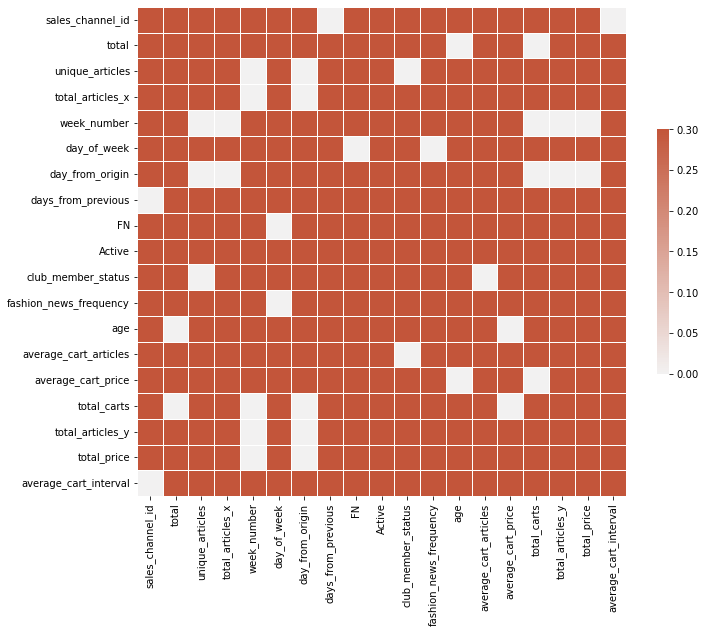

In [24]:
p = p_values(carts_sampled.drop(
    [
        "customer_id", 
        "t_dat", 
        "content",
        "postal_code"
    ], 1))

heatmap(p)


**Observations**

- Corrélation significative entre le contenu du panier (`unique_articles`) et l'intervalle au précédent. (`days_from_previous`)
- Corrélation significative entre le volume d'achat du client (`total_carts`, `total_articles_y`, `total_price`) et l'intervalle au précédent. (`days_from_previous`)
- Le jour d'achat (`day_of_year`) est légèrement corrélé avec le nombre d'articles dans le panier et l'intervalle au précédent. (`days_from_previous`)
- Peu de variables que l'on peut considérer comme indépendantes deux-à-deux.


## Conclusion

- Des corrélations existent entre les caractéristiques des clients, les caractéristiques des produits et le volume des ventes.
- Les caractéristiques du produit ont une certain influence sur la date d'achat.
- Les caractéristiques du client semblent avoir peu d'influence sur la date d'achat
- Corrélation significative entre le contenu du panier et l'intervalle au précédent.

-> Une analyse statique (ne tenant pas compte des aspects temporels) pourra peut-être avoir quelques résultats mais sera très probablement limitée, au vu des relations observées entre les différentes informations.

**-> À travers l'étude de l'intervalle entre les paniers, on confirme qu'une analyse temporelle serait pertinente.** D'autres intervalles temporels pourrait être étudiés (= entre deux achats d'un même produit, etc) avant ou après l'élaboration d'un premier modèle.
